In [63]:
import gym
import random
import pandas as pd
import numpy as np
from sklearn import preprocessing
import math
from gym_go import state_utils, govars

import matplotlib.pyplot as plt
# import seaborn as sns

from scipy.stats import iqr
import pickle


In [64]:
# 1. Structure
# mini-batch to update several states at the same time
# use target network to gain stablility
# replay buffer: iid for SGD optimization
# 2. Add Symmetry trick 
# 3. Add Layer
# 3. Get Value Function

In [65]:
import sys, os
sys.path.append(os.getcwd())
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
import copy

import gym
from TDRC.DQRC import DQRC

In [66]:
TARGET_REFRESH = 1
ALPHA = 0.0009765
size = 3
sample_size = 4

env = gym.make('gym_go:go-v0', size=3)

In [67]:
# build the structure of our neural network
# we need to output both the last layer and the second to last layer
# TODO: add layer and nodes
class Network(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear((size**2)*2, sample_size),
            nn.ReLU(),
            nn.Linear(sample_size, sample_size),
            nn.ReLU(),
        )

        self.output = nn.Linear(sample_size, size**2)

    def forward(self, x):
        features = self.model(x)
        outputs = self.output(features)
        return outputs, features

# build the target and policy networks
# the target net is the same as the policy net, but with the weights occupying different memory

policy_network = Network()
target_network = copy.deepcopy(policy_network)
optimizer = optim.Adam(policy_network.parameters(), lr = ALPHA, betas=(0.9, 0.999))

# construct our TDRC agent
agent = TDRC(sample_size, size**2, policy_network, target_network, optimizer, {
    'alpha': ALPHA,
    'beta': 1.0,
    'epsilon': 0.1,
})



# much much faster than np.random.choice
def choice(arr, size=1):
    idxs = np.random.permutation(len(arr))
    return [arr[i] for i in idxs[:size]]

# a very simple circular replay buffer

class ReplayBuffer:
    def __init__(self, buffer_size):
        self.buffer_size = buffer_size
        self.location = 0
        self.buffer = []

    def __len__(self):
        return len(self.buffer)

    def add(self, args):
        if len(self.buffer) < self.buffer_size:
            self.buffer.append(args)
        else:
            self.buffer[self.location] = args
        self.location = (self.location + 1) % self.buffer_size

    def sample(self, batch_size):
        return choice(self.buffer, batch_size)



In [68]:
env = gym.make('gym_go:go-v0', size=size, reward_method = 'heuristic')
# ---------------------
# Start the experiments
# ---------------------
buffer = ReplayBuffer(4000)
s = env.reset()
x = torch.tensor(np.concatenate((s[0].reshape(size**2),s[1].reshape(size**2)), axis=None), dtype=torch.float32).unsqueeze(0)

episode_lengths = []
episode_reward = []
steps = 0
for step in range(100000):
    steps += 1
    if step % TARGET_REFRESH == 0:
        target_network.load_state_dict(policy_network.state_dict())

    
    q_s, _ = agent.policy_net(x)
    q_s = q_s.detach().cpu().numpy()
    
   
    q_s = [float('-inf') if s[3].reshape(size**2)[i] == 1 else q_s[0][i] for i in range(9)]
    
    action = np.array(q_s).argmax()

    
    sp, reward, done, info = env.step(action)
    
    
    
    
    
    
    episode_reward.append(reward)

    # termination only occurs if we hit the terminal state
    # not if we hit the #episode length cap
    terminated = done and steps < 1000

    xp = torch.tensor(np.concatenate((s[0].reshape(size**2),s[1].reshape(9)), axis=None), dtype=torch.float32).unsqueeze(0)
    
    if terminated:
        xp = None

    a = torch.tensor(action, dtype=torch.int64)
    r = torch.tensor(reward, dtype=torch.float32).unsqueeze(0)

    # use a state-based gamma where gamma = 0.99 of all states
    # and gamma = 0 for the terminal state
    gamma = torch.tensor(0 if terminated else 0.99)
    buffer.add((x, a, r, xp, gamma))

    # once the buffer has enough samples to start updating
    # then start updating
    if step > sample_size:
        samples = buffer.sample(sample_size)
        agent.updateNetwork(samples)
        
    

    s = sp
    x = xp
    

    if done or sum(s[3].reshape(size**2))==size**2:
        print(steps)
        episode_lengths.append(steps)
        steps = 0
        s = env.reset()
        x = torch.tensor(np.concatenate((s[0].reshape(size**2),s[1].reshape(9)), axis=None), dtype=torch.float32).unsqueeze(0)

    else:
        action = env.uniform_random_action()
        state, reward, done, info = env.step(action)
        
        s = state
        xp = torch.tensor(np.concatenate((s[0].reshape(size**2),s[1].reshape(9)), axis=None), dtype=torch.float32).unsqueeze(0)
   
        x = xp
        
        
        if done or sum(s[3].reshape(9))==9:
            print(steps)
            episode_lengths.append(steps)
            steps = 0
            s = env.reset()
            x = torch.tensor(np.concatenate((s[0].reshape(size**2),s[1].reshape(9)), axis=None), dtype=torch.float32).unsqueeze(0)


    
    
    
    
    
#env.close()

4
5
5
4
7
6
8
4
4
7
12
4
5
6
6
6
6
5
6
5
8
7
5
7
5
6
5
5
4
5
11
4
4
9
5
6
9
7
6
6
13
4
5
7
4
4
5
7
5
5
6
5
4
6
7
4
5
6
5
5
5
5
4
5
4
6
7
5
4
5
5
5
6
10
4
5
8
4
7
6
6
6
8
7
17
4
8
8
8
9
5
5
7
4
8
17
7
8
6
8
4
7
5
8
8
6
5
7
7
5
5
6
7
7
4
5
7
5
5
5
7
5
5
7
7
5
8
5
6
7
5
5
6
6
9
14
4
6
7
7
7
8
4
5
4
6
5
4
4
4
4
6
5
6
7
5
4
5
7
6
7
6
7
5
4
5
4
5
6
6
6
5
8
5
7
10
5
5
5
7
6
5
6
4
4
6
12
5
7
4
7
4
10
6
6
6
5
5
7
6
13
6
13
4
4
11
5
13
12
5
8
11
5
6
5
7
6
5
7
12
5
5
8
5
5
9
9
5
6
14
7
8
4
5
7
6
7
4
7
5
4
5
5
13
6
6
4
4
5
5
5
5
8
6
5
4
12
6
7
6
10
4
8
4
4
5
7
5
5
6
7
5
6
9
4
5
11
7
9
12
4
9
7
6
4
8
6
5
8
5
4
5
5
6
4
4
10
6
4
7
5
5
14
6
5
6
5
5
4
5
7
7
10
5
6
5
4
8
5
9
5
4
5
5
6
4
5
4
4
6
7
4
5
4
5
6
5
5
4
4
4
5
5
8
5
5
6
6
5
5
6
5
5
11
10
9
6
6
5
6
5
7
4
4
6
11
4
6
6
4
8
6
6
7
4
5
5
10
5
4
6
4
8
6
5
7
7
7
4
6
4
5
16
7
4
6
5
7
4
4
5
10
6
5
10
4
8
7
5
15
6
12
4
5
5
5
7
5
7
6
7
6
5
16
16
7
7
21
8
8
11
7
6
4
7
5
4
5
4
5
4
20
6
6
5
4
9
9
5
4
4
4
4
4
4
15
7
4
4
6
4
9
4
6
8
5
4
4
6
4
7
4
6
7
6
5
4
5
8
5

20
4
7
4
4
4
5
9
4
8
8
8
5
6
5
6
5
5
4
4
4
4
5
5
6
4
6
6
5
4
5
4
6
5
6
7
7
8
5
5
6
6
6
6
10
8
6
5
5
4
6
5
4
7
4
5
4
8
4
20
6
5
7
6
13
6
7
4
7
5
5
4
7
5
6
7
6
4
4
5
7
5
4
6
4
5
5
6
4
5
4
6
4
4
12
5
8
8
6
7
7
4
4
4
8
4
4
7
6
7
4
7
5
8
5
5
8
7
8
4
7
6
4
8
6
7
6
5
14
5
6
4
8
5
6
4
6
4
6
4
4
5
6
7
6
9
4
6
5
5
5
5
4
6
8
9
7
10
4
7
8
5
4
6
6
4
4
6
4
4
9
6
4
7
7
8
7
9
5
7
5
5
5
5
5
8
8
5
6
7
4
5
8
4
11
4
6
4
10
14
5
5
4
6
6
9
4
4
6
4
6
6
6
7
5
4
6
12
4
4
4
4
5
4
6
5
6
7
6
4
5
8
6
6
6
6
7
5
6
4
5
4
4
6
6
6
5
4
4
5
6
12
5
6
4
5
8
4
7
5
6
6
6
4
4
6
4
4
5
4
4
4
4
4
5
4
4
6
8
4
5
4
5
5
6
5
5
5
4
4
5
5
4
6
6
4
7
5
6
7
4
5
7
4
6
4
6
5
6
4
13
4
8
7
4
4
5
6
4
4
5
4
6
7
6
5
4
4
6
6
8
4
4
5
6
5
4
5
4
7
4
4
4
4
8
7
6
5
5
14
4
4
4
6
7
7
4
6
7
6
4
4
4
5
7
6
6
4
4
4
6
4
5
4
6
4
6
6
5
6
7
4
8
6
7
6
5
6
4
7
4
4
7
4
4
4
5
6
5
7
5
6
5
4
6
5
4
4
5
5
7
5
5
4
6
5
5
6
5
5
5
5
4
4
4
4
7
4
4
5
4
6
8
4
6
4
4
6
6
5
5
6
4
6
6
5
4
5
6
5
5
8
4
4
4
4
6
4
4
4
11
4
20
5
4
4
5
5
6
6
4
4
4
6
6
6
5
4
4
7
5
7
4
13
4
6
6
5
5
4
6
7

5
5
8
6
5
7
5
5
11
5
4
4
8
5
4
4
4
4
6
7
5
12
4
4
6
4
5
6
7
4
6
6
4
6
11
16
4
4
4
4
7
6
6
7
6
7
5
4
5
6
5
4
7
6
5
4
5
4
6
8
5
8
4
9
5
6
17
5
5
6
6
6
8
5
6
7
9
7
4
6
8
6
5
8
5
4
4
6
4
9
8
4
7
4
5
5
23
7
5
6
6
8
7
6
4
22
6
5
6
4
4
5
4
12
6
6
6
8
5
9
8
4
4
5
6
7
4
6
5
6
4
12
6
13
8
10
5
4
6
8
8
4
5
4
5
4
4
8
7
7
4
5
4
13
4
4
10
6
8
9
8
6
6
11
13
8
7
6
8
7
6
6
6
14
10
6
7
7
4
8
6
6
5
8
20
6
4
5
5
6
6
7
4
6
4
5
5
7
4
6
5
6
6
4
6
4
4
4
6
6
4
11
20
4
6
6
5
5
4
6
5
5
5
8
6
4
6
5
4
4
4
5
10
6
7
6
5
7
9
5
4
9
7
7
6
5
6
6
12
5
6
6
4
5
4
4
5
4
6
6
7
4
4
6
4
5
26
8
9
7
12
14
4
4
4
6
5
4
6
6
7
5
5
8
9
6
13
13
10
7
6
10
5
5
6
4
8
6
7
12
4
13
6
5
10
6
6
4
5
6
7
4
7
4
6
7
5
6
6
6
8
6
7
4
8
8
6
5
7
9
5
8
4
5
5
4
5
5
4
10
7
4
8
6
6
4
5
5
6
7
7
5
5
6
4
8
4
6
5
6
5
5
8
7
4
7
8
11
4
5
7
4
18
7
16
5
10
10
4
4
10
7
5
5
7
6
5
5
5
7
9
5
8
6
5
6
4
7
8
5
4
6
5
6
6
7
8
5
4
4
4
4
4
4
4
6
6
6
4
7
6
7
5
5
6
4
21
5
6
6
6
5
13
7
4
5
4
4
8
5
4
4
6
14
4
6
7
5
6
5
7
12
15
11
4
6
6
5
4
11
4
14
6
5
4
5
5
4
8
12
4
5
6
5
5
7


6
11
5
5
6
5
5
4
9
4
7
4
5
4
5
5
4
4
5
5
4
8
4
8
7
4
7
4
4
4
4
5
4
4
7
4
7
5
5
7
6
6
6
6
4
9
4
4
4
7
4
13
4
8
8
5
8
4
7
4
4
5
4
6
5
10
4
5
6
4
4
5
6
5
5
5
4
5
4
5
6
7
4
6
11
18
6
5
5
6
4
6
12
6
5
11
4
4
5
6
5
4
4
4
4
4
7
6
5
6
14
8
6
7
5
6
4
4
6
5
6
5
6
8
5
9
8
4
7
6
7
6
6
8
6
7
7
5
4
4
7
5
5
4
4
13
5
13
6
4
9
4
4
8
7
8
6
6
4
4
6
7
6
4
5
6
6
7
14
9
6
8
4
8
15
4
15
5
8
12
4
5
5
5
15
4
6
5
8
6
5
6
4
6
5
7
4
6
4
4
7
5
6
6
5
8
4
8
5
5
4
4
13
6
6
7
6
4
4
5
5
14
5
6
7
6
10
6
4
4
6
9
5
4
8
4
4
5
4
4
5
4
7
6
5
6
4
5
8
5
6
5
4
4
4
4
4
10
10
4
4
4
5
8
4
11
4
5
4
4
7
7
4
7
6
7
5
5
6
4
12
4
7
9
14
4
4
4
8
7
6
7
6
6
11
17
4
10
4
7
5
9
5
5
5
5
6
9
4
4
8
5
9
4
12
7
5
7
5
8
5
6
5
4
10
5
6
8
6
6
10
4
6
6
10
6
6
6
7
6
6
5
8
8
7
4
5
5
14
13
4
7
19
4
4
5
8
8
6
5
4
4
4
4
6
4
5
5
6
6
5
5
12
7
8
4
6
6
4
5
7
4
8
4
11
6
12
7
5
5
5
7
6
4
4
4
12
8
9
7
6
4
5
5
12
13
4
6
8
8
4
11
7
6
8
8
5
11
7
10
8
4
6
4
4
5
5
4
4
4
6
5
4
4
5
4
4
7
8
7
5
6
6
4
8
5
6
8
7
4
14
6
4
7
5
12
7
6
5
11
5
5
4
8
5
4
8
7
11
6
6
6
4
6
4
4
5


14
5
6
13
8
4
7
9
4
4
4
4
4
4
6
6
14
7
4
4
10
5
4
5
11
6
6
6
7
5
7
6
5
8
8
6
6
14
14
7
6
5
14
10
5
12
16
5
6
4
4
4
8
7
4
9
10
7
5
7
7
11
5
6
4
5
7
5
7
5
4
7
4
6
7
4
4
13
8
4
11
14
7
7
15
9
5
5
8
4
7
9
6
5
8
5
4
5
5
4
7
4
6
8
6
13
7
6
9
4
5
5
5
5
7
4
7
6
10
6
4
5
4
4
4
4
4
6
6
7
8
5
7
7
4
6
6
4
6
4
8
7
5
8
5
7
4
6
7
8
4
15
10
6
4
5
5
6
10
7
6
5
7
5
5
8
8
4
5
6
7
4
9
5
5
7
6
7
12
7
6
11
12
4
6
4
4
5
6
6
4
17
5
7
5
8
8
6
7
4
4
5
6
7
5
4
5
4
4
7
5
5
4
5
9
7
10
8
9
7
8
12
7
4
8
4
4
4
7
4
6
21
8
6
5
6
12
16
6
10
6
8
5
4
6
7
17
4
13
8
5
4
5
6
5
6
5
5
6
8
5
4
5
10
8
8
6
13
8
4
5
6
9
4
6
5
5
4
5
6
8
6
8
4
4
6
5
8
6
8
18
4
4
7
5
8
8
7
4
4
14
5
5
5
4
6
6
4
8
4
4
6
10
7
12
4
12
4
4
5
16
13
5
4
4
5
4
5
8
4
5
10
4
6
21
4
6
7
8
5
5
6
4
6
6
7
5
5
12
5
9
6
15
8
4
8
9
5
7
17
4
6
5
6
5
5
6
8
4
4
9
7
10
4
5
5
4
6
4
6
11
10
15
11
5
6
6
6
5
4
10
5
4
5
4
4
6
5
4
6
4
4
4
8
11
6
10
11
4
5
6
6
6
17
6
4
4
6
8
5
4
6
5
6
6
6
8
6
6
6
6
8
7
7
5
13
4
5
4
9
7
6
7
7
6
6
4
4
4
5
5
5
6
6
6
8
7
5
16
6
4
6
7
6
8
6
6
6
7
12

In [73]:
env = gym.make('gym_go:go-v0', size=size, reward_method = 'heuristic')
# ---------------------
# Start the experiments
# ---------------------
buffer = ReplayBuffer(4000)
s = env.reset()
x = torch.tensor(np.concatenate((s[0].reshape(size**2),s[1].reshape(size**2)), axis=None), dtype=torch.float32).unsqueeze(0)

episode_lengths = []
episode_reward_r = []
steps = 0
for step in range(100000):
    
    action = env.uniform_random_action()
    state, reward, done, info = env.step(action)
    
    episode_reward_r.append(reward)
    

    if done :
        env.reset()
        
    else:
        action = env.uniform_random_action()
        state, reward, done, info = env.step(action)
        
        
        if done:
            env.reset()

    
    
    
    
    
#env.close()

(0.0, 0.5)

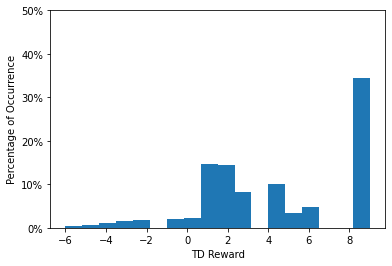

In [79]:
plt.hist(episode_reward, weights=np.ones(len(episode_reward)) / len(episode_reward), bins = 18)
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.ylabel('Percentage of Occurrence')
plt.xlabel('TD Reward')
plt.ylim([0, 0.5])

(0.0, 0.5)

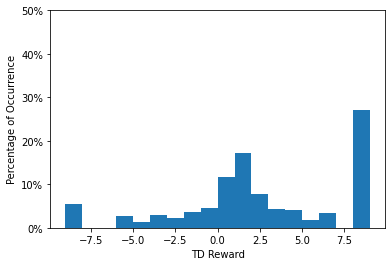

In [80]:
from matplotlib.ticker import PercentFormatter
plt.hist(episode_reward_r, weights=np.ones(len(episode_reward_r)) / len(episode_reward_r), bins = 18)
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.ylabel('Percentage of Occurrence')
plt.xlabel('TD Reward')
plt.ylim([0, 0.5])